In [2]:
import sys
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

sys.path.append(str(Path("src").resolve()))

from ddh.pipeline import run_toy_pipeline
from ddh.io_handlers import load_toy_data
from ddh.graphs import build_ppi_graph
from ddh.scoring import build_drug_target_map, build_disease_gene_map

In [3]:
data_dir = Path("../data/toy") 

df = run_toy_pipeline(data_dir=data_dir, alpha=1.0, beta=1.0)
df.head()

,drug_id,disease_id,mean_distance,proximity_score,n_overlap,overlapping_genes,jaccard,norm_overlap,combined_score,drug_name,disease_name
0,D1,DIS1,0.50,0.666667,2.0,G1;G2,1.000000,1.0,1.666667,DrugA,DiseaseOne
1,D2,DIS2,0.50,0.666667,2.0,G2;G3,1.000000,1.0,1.666667,DrugB,DiseaseTwo
2,D3,DIS3,0.00,1.000000,1.0,G4,1.000000,0.5,1.500000,DrugC,DiseaseThree
3,D1,DIS2,0.75,0.571429,1.0,G2,0.333333,0.5,1.071429,DrugA,DiseaseTwo
4,D2,DIS1,0.75,0.571429,1.0,G2,0.333333,0.5,1.071429,DrugB,DiseaseOne


In [4]:
top_k = 10
df_top = df.head(top_k).copy()
df_top

,drug_id,disease_id,mean_distance,proximity_score,n_overlap,overlapping_genes,jaccard,norm_overlap,combined_score,drug_name,disease_name
0,D1,DIS1,0.50,0.666667,2.0,G1;G2,1.000000,1.0,1.666667,DrugA,DiseaseOne
1,D2,DIS2,0.50,0.666667,2.0,G2;G3,1.000000,1.0,1.666667,DrugB,DiseaseTwo
2,D3,DIS3,0.00,1.000000,1.0,G4,1.000000,0.5,1.500000,DrugC,DiseaseThree
3,D1,DIS2,0.75,0.571429,1.0,G2,0.333333,0.5,1.071429,DrugA,DiseaseTwo
4,D2,DIS1,0.75,0.571429,1.0,G2,0.333333,0.5,1.071429,DrugB,DiseaseOne
5,D2,DIS3,1.50,0.400000,0.0,NaN,NaN,0.0,0.400000,DrugB,DiseaseThree
6,D3,DIS2,1.50,0.400000,0.0,NaN,NaN,0.0,0.400000,DrugC,DiseaseTwo
7,D1,DIS3,2.00,0.333333,0.0,NaN,NaN,0.0,0.333333,DrugA,DiseaseThree
8,D3,DIS1,2.00,0.333333,0.0,NaN,NaN,0.0,0.333333,DrugC,DiseaseOne


In [5]:
top_pair = df_top.iloc[0]

top_pair

drug_id                      D1
disease_id                 DIS1
mean_distance               0.5
proximity_score        0.666667
n_overlap                   2.0
overlapping_genes         G1;G2
jaccard                     1.0
norm_overlap                1.0
combined_score         1.666667
drug_name                 DrugA
disease_name         DiseaseOne
Name: 0, dtype: object

In [6]:
drugs, genes, diseases, dts, gds, ppis = load_toy_data(data_dir)
G_ppi = build_ppi_graph(ppis)

# Build maps for quick lookup
drug_to_genes = build_drug_target_map(dts)
disease_to_genes = build_disease_gene_map(gds)

drug_id = top_pair["drug_id"]
disease_id = top_pair["disease_id"]

drug_genes = drug_to_genes[drug_id]
disease_genes = disease_to_genes[disease_id]
overlap_genes = set(str(top_pair["overlapping_genes"]).split(";"))

print("Drug:", top_pair["drug_name"], f"({drug_id})")
print("Disease:", top_pair["disease_name"], f"({disease_id})")
print("Drug target genes:", drug_genes)
print("Disease genes:", disease_genes)
print("Overlapping genes:", overlap_genes)

Drug: DrugA (D1)
Disease: DiseaseOne (DIS1)
Drug target genes: {'G2', 'G1'}
Disease genes: {'G2', 'G1'}
Overlapping genes: {'G2', 'G1'}


In [7]:
# Genes we care about: union of drug targets and disease genes
focus_genes = set(drug_genes) | set(disease_genes)

# Expand by 1-hop neighbors in the PPI graph
neighbors = set()
for g in focus_genes:
    if g in G_ppi:
        neighbors.update(G_ppi.neighbors(g))

sub_nodes = focus_genes | neighbors
sub_G = G_ppi.subgraph(sub_nodes).copy()

print(f"Subgraph: {sub_G.number_of_nodes()} nodes, {sub_G.number_of_edges()} edges")

Subgraph: 3 nodes, 3 edges


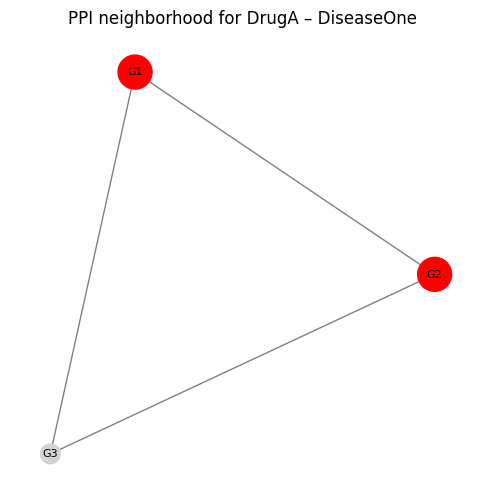

In [8]:
# Define colors/labels
node_colors = []
node_sizes = []

for node in sub_G.nodes():
    if node in overlap_genes:
        node_colors.append("red")
        node_sizes.append(600)
    elif node in drug_genes:
        node_colors.append("orange")
        node_sizes.append(400)
    elif node in disease_genes:
        node_colors.append("blue")
        node_sizes.append(400)
    else:
        node_colors.append("lightgray")
        node_sizes.append(200)

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(sub_G, seed=42)

nx.draw_networkx_nodes(sub_G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(sub_G, pos, alpha=0.5)
nx.draw_networkx_labels(sub_G, pos, font_size=8)

plt.title(f"PPI neighborhood for {top_pair['drug_name']} – {top_pair['disease_name']}")
plt.axis("off")
plt.show()

In [9]:
rows = []
for g in sorted(sub_G.nodes()):
    rows.append(
        {
            "gene_id": g,
            "is_drug_target": g in drug_genes,
            "is_disease_gene": g in disease_genes,
            "is_overlap": g in overlap_genes,
            "degree_in_subgraph": sub_G.degree[g],
        }
    )

pd.DataFrame(rows)

,gene_id,is_drug_target,is_disease_gene,is_overlap,degree_in_subgraph
0,G1,True,True,True,2
1,G2,True,True,True,2
2,G3,False,False,False,2
